# Quickstart

This notebook is intended to demonstrate the basic usage of `superscreen` by calculating the magnetic response of several simple single-layer devices.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16

import superscreen as sc

## Device geometry and materials

- **Layers** represent different physical planes in a device. All superconducting films in a given layer
  are assumed to have the same thickness and penetration depth.
- **Films** represent the actual superconducting films, which may fill only part of the `Layer` that they are in,
  and may have one or more holes. Each film can have an arbitrary polygonal geometry, and there can be multiple         (non-overlapping) films per layer.
- **Holes** are polygonal regions of vacuum completely surrounded (in 2D) by a superconducting film, which can contain   trapped flux.
- **Abstract regions** are polygonal regions which need not represent any real geometry in the device.   Abstract regions will be meshed just like films and holes, and after solving a `Device`, one can calculate the flux through all abstract regions. Abstract regions can be used to define a "bounding box," a region of vacuum outside of the convex hull of all the films that will be meshed and simulated.

## Superconducting disk

Here we define a superconducting disk of radius 4 $\mu$m with London penetration depth $\lambda=100$ nm and a thickness $d=25$ nm, for an effective penetration depth of $\Lambda=\lambda^2/d=400$ nm.

In [2]:
length_units = "um"

layers = [
    sc.Layer("base", london_lambda=0.1, thickness=0.025, z0=0),
]

films = [
    sc.Polygon("disk", layer="base", points=sc.geometry.circle(4, points=400)),
]

holes = []

abstract_regions = [
    sc.Polygon("bounding_box", layer="base", points=sc.geometry.circle(5.5, points=100)),
]

device = sc.Device(
    "disk",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units=length_units,
)

In [3]:
print(device)

Device(
    "disk", 
    layers=[
        Layer("base", Lambda=0.400, thickness=0.025, london_lambda=0.100, z0=0.000),
    ], 
    films=[
        Polygon("disk", layer="base", points=ndarray[shape=(401, 2)]),
    ], 
    holes=None, 
    abstract_regions=[
        Polygon("bounding_box", layer="base", points=ndarray[shape=(101, 2)]),
    ], 
    length_units="um",
)


### Generate the mesh

In [4]:
device.make_mesh(min_triangles=8_000, optimesh_steps=20)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 8022 triangles.
INFO:superscreen.device:Finished generating mesh with 4072 points and 8022 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


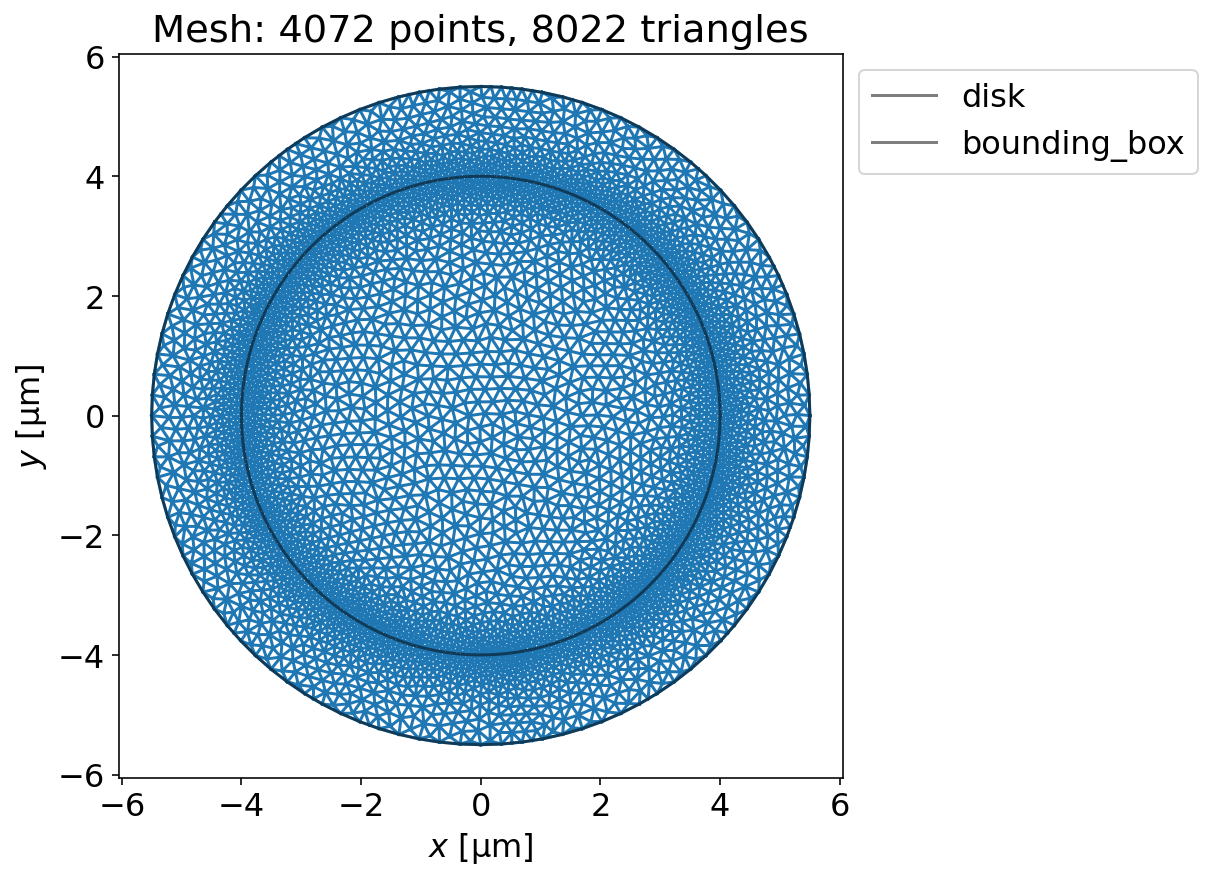

In [5]:
fig, ax = device.plot_polygons(color='k', alpha=0.5, plot_mesh=True)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, "
    f"{device.triangles.shape[0]} triangles"
)

### Simulate Meissner screening

Here we apply a uniform field field in the $+z$ direction and calculate the disk's magnetic response.

In [6]:
applied_field = sc.sources.ConstantField(1)

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    field_units="uT",
    current_units="uA",
)
assert len(solutions) == 1
solution = solutions[-1]

INFO:superscreen.brandt:Calculating base response to applied field.


In [7]:
xs = np.linspace(-5, 5, 401)

cross_section_coords = [
    # [x-coords, y-coords]
    np.stack([xs, xs], axis=1) / np.sqrt(2), # diagonal cross-section
    np.stack([xs, 3 * np.ones_like(xs)], axis=1), # horizontal cross-section
]

#### Visualize the fields

We expect to see only the applied field far outside the disk, approximately 0 $\mu$T inside the disk, and a sharp peak just outside the disk due to Meissner screening.

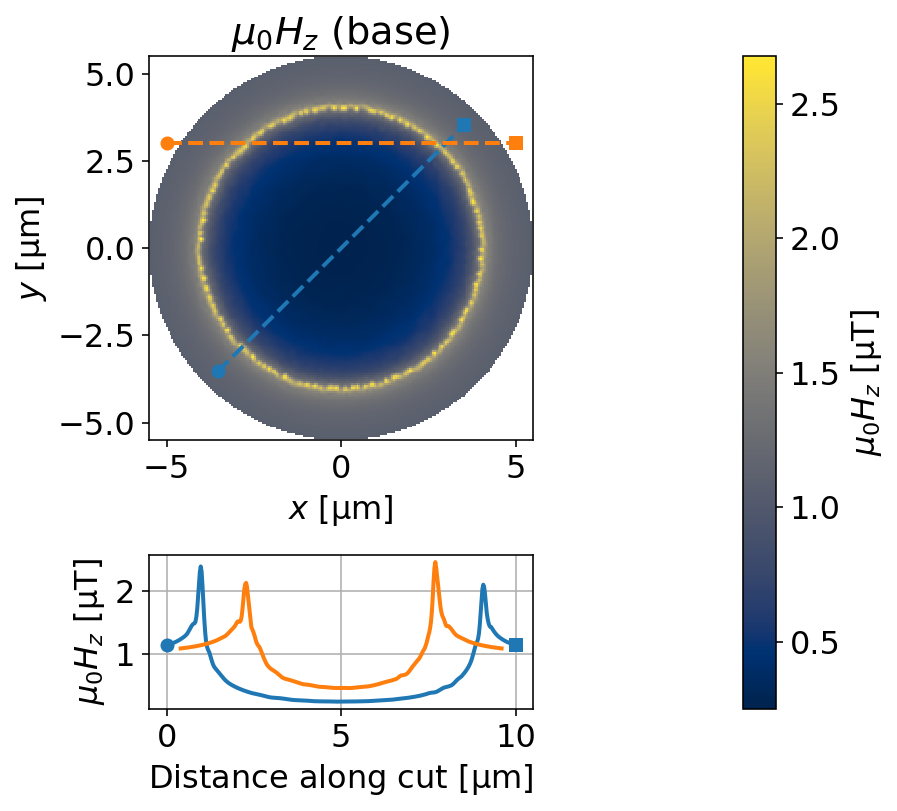

In [8]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords,
    auto_range_cutoff=0.01,
)

#### Visualize the currents

We expect to see counterclockwise circulating current in the disk, which generates a screening field in the $-z$ direction to cancel the field applied in the $+z$ direction.

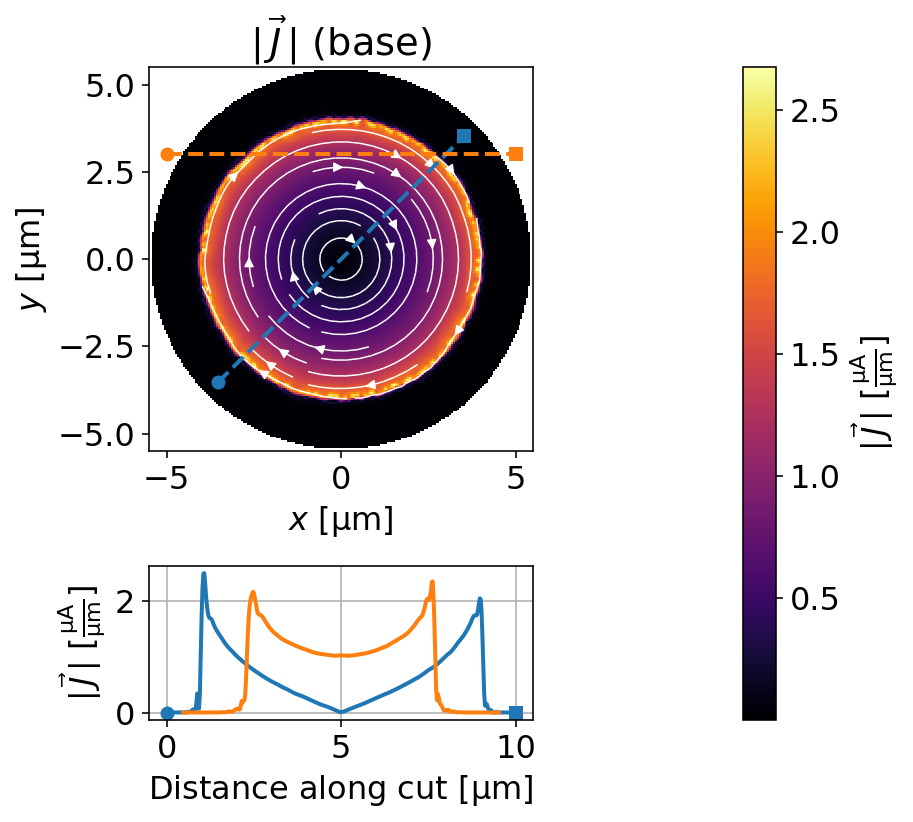

In [9]:
fig, axes = solution.plot_currents(
    units="uA/um",
    cross_section_coords=cross_section_coords,
)

## Superconducting ring

Let's see what happens if we add a hole to our device (making it a ring or washer).

In [10]:
holes = [
    sc.Polygon("hole", layer="base", points=sc.geometry.circle(2))
]

device = sc.Device(
    "ring",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units=length_units,
)

In [11]:
device.make_mesh(min_triangles=8_000, optimesh_steps=20)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 8005 triangles.
INFO:superscreen.device:Finished generating mesh with 4055 points and 8005 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


In [12]:
fig, ax = device.plot_polygons(ax=ax, color='k', alpha=0.5, plot_mesh=True)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, "
    f"{device.triangles.shape[0]} triangles"
)

### Uniform applied field

First, let's look at the response of the ring to the same uniform field that we applied to the [disk](#Superconducting-disk) above (assuming no flux trapped in the center of the ring).

In [13]:
applied_field = sc.sources.ConstantField(1)

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    field_units="uT",
    current_units="uA",
)
solution = solutions[-1]

INFO:superscreen.brandt:Calculating base response to applied field.


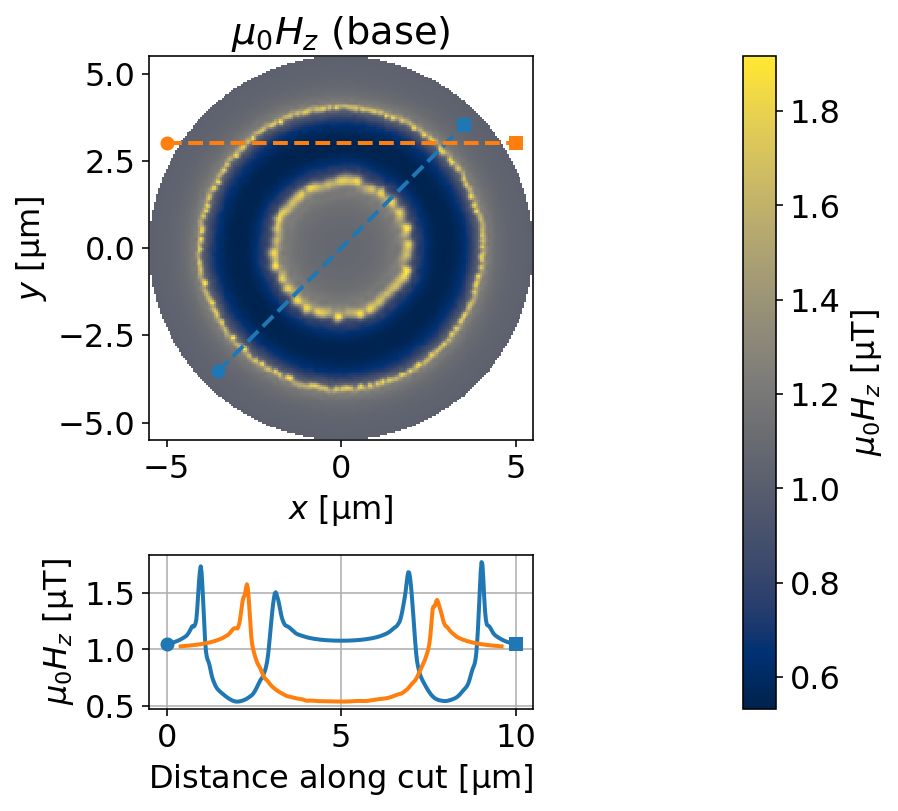

In [14]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords,
    auto_range_cutoff=0.01,
)

Note that, in contrast with the full [disk](#Superconducting-disk), the screening currents are flowing in opposite directions in the inner and outer areas of the ring.

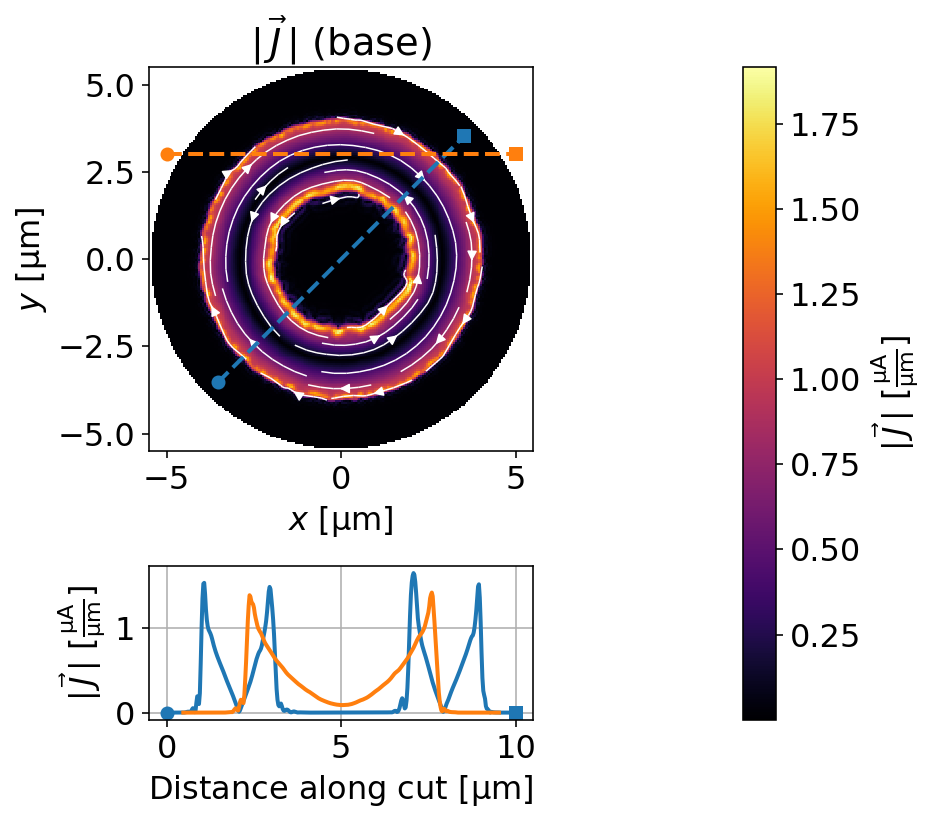

In [15]:
fig, axes = solution.plot_currents(
    units="uA/um",
    cross_section_coords=cross_section_coords,
)

### Trapped flux

We can also solve for the field and current distribution from circulating currents associated with flux trapped in the hole.

We assume there is a total current of 1 $\mu$A circulating clockwise in the ring (associated with some positive net trapped flux), and that there is otherwise no applied magnetic field. From here we can calculate the current distribution in the ring, the total magnetic field in the plane of the ring, and the flux through the ring.

Note that, although here we are assuming no applied field, we can also solve models with both trapped flux and applied fields.

In [16]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "hole": "1 uA",
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="uT",
    current_units="uA",
)
solution = solutions[-1]

INFO:superscreen.brandt:Calculating base response to applied field.


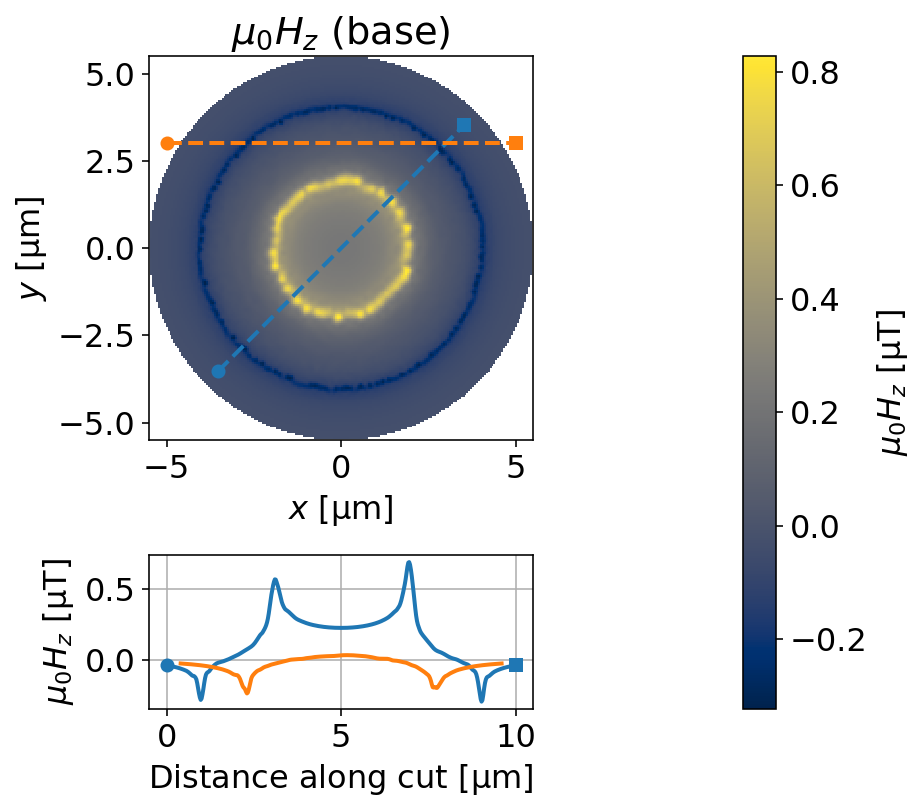

In [17]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords,
    auto_range_cutoff=0.01,
)

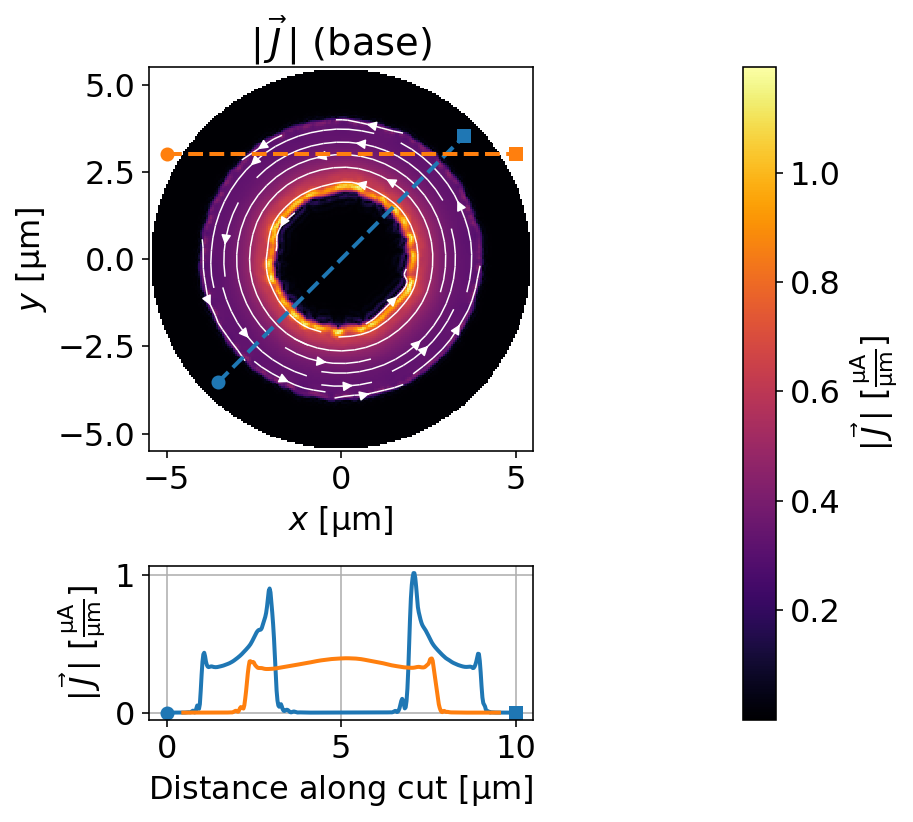

In [18]:
fig, axes = solution.plot_currents(
    units="uA/um",
    cross_section_coords=cross_section_coords,
)

### Calculate flux and self-inductance

We will take the inductance to be the total flux through the ring (the flux through the hole and the flux through the superconducting film) divided by the circulating current.

The flux through each polygon in the device is calculated by integrating $\mu_0H_z(x, y, z_{0,\,\mathrm{layer}})$ over the area of the polygon. Note that because the "hole" polygon lies within the "disk" polygon, for the inductance calculation we only have to worry about the flux through the "disk".

In [19]:
current = device.ureg(circulating_currents["hole"])

flux = solution.polygon_flux()

self_inductance = (flux["disk"] / current).to("pH")

display(flux)
print(f"The circulating current is: {current:.3f~P}.")
print(
    f"The total flux through the ring is: {flux['disk']:.3f~P}"
    f" = {flux['disk'].to('mPhi_0'):.3f~P}."
)
print(f"The ring's self-inductance is: {self_inductance:.3f~P}.")

{'disk': 5.979655175330258 <Unit('micrometer ** 2 * microtesla')>,
 'hole': 4.511011581628258 <Unit('micrometer ** 2 * microtesla')>,
 'bounding_box': 2.9722485956740163 <Unit('micrometer ** 2 * microtesla')>}

The circulating current is: 1.000 µA.
The total flux through the ring is: 5.980 µT·µm² = 2.892 mΦ_0.
The ring's self-inductance is: 5.980 pH.


## Film with multiple holes

Here we simulate a device with fewer symmetries than the disk or ring, namely a rectangular film with two off-center rectangular holes.

In [20]:
length_units = "um"

layers = [
    sc.Layer("base", Lambda=0.1, z0=0),
]

films = [
    sc.Polygon("film", layer="base", points=sc.geometry.rectangle(8, 4)),
]

holes = [
    sc.Polygon(
        "hole0",
        layer="base",
        points=sc.geometry.rectangle(5, 1, center=(0.5, -0.25))
    ),
    sc.Polygon(
        "hole1",
        layer="base",
        points=sc.geometry.rectangle(1, 2.5, center=(-3, 0.25))
    ),
]

abstract_regions = [
    sc.Polygon("bounding_box", layer="base", points=sc.geometry.rectangle(9, 5)),
]

device = sc.Device(
    "rect",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units=length_units,
)

In [21]:
device.make_mesh(min_triangles=8_000)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Finished generating mesh with 4292 points and 8328 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


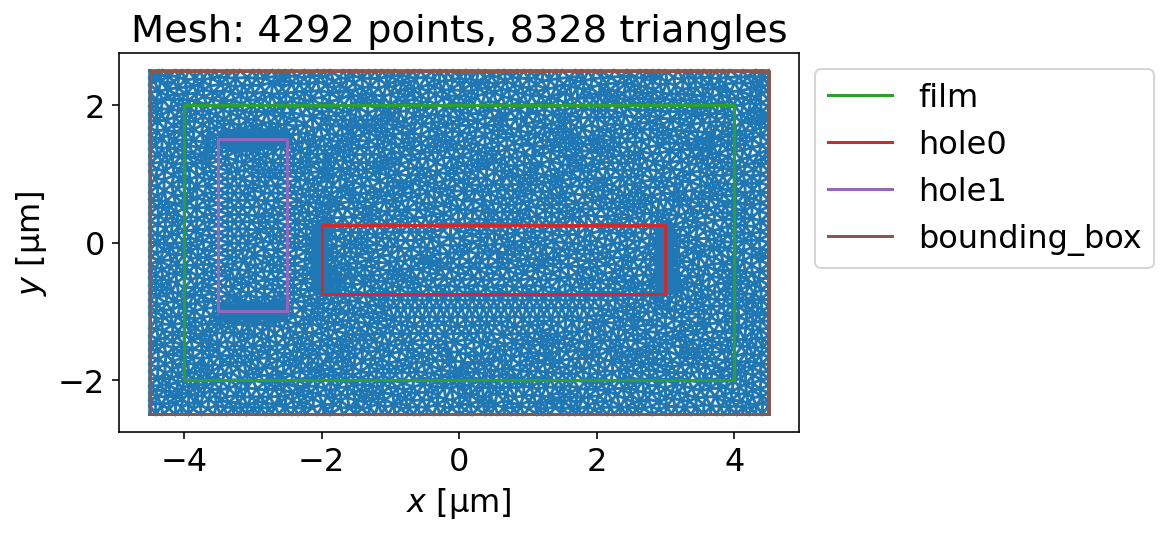

In [22]:
fig, ax = device.plot_polygons(plot_mesh=True)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, "
    f"{device.triangles.shape[0]} triangles"
)

### Uniform field

Here we apply the same uniform field as we did to the [disk](#Simulate-Meissner-screening) and [ring](#Uniform-applied-field), assuming no trapped flux in either hole.

In [23]:
applied_field = sc.sources.ConstantField(1)

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=None,
    field_units="uT",
    current_units="uA",
)
solution = solutions[-1]

INFO:superscreen.brandt:Calculating base response to applied field.


In [24]:
cross_section_coords = [
    np.stack([np.linspace(-4.5, 4.5, 401), y * np.ones(401)], axis=1)
    for y in (0, 1, 1.75)
]

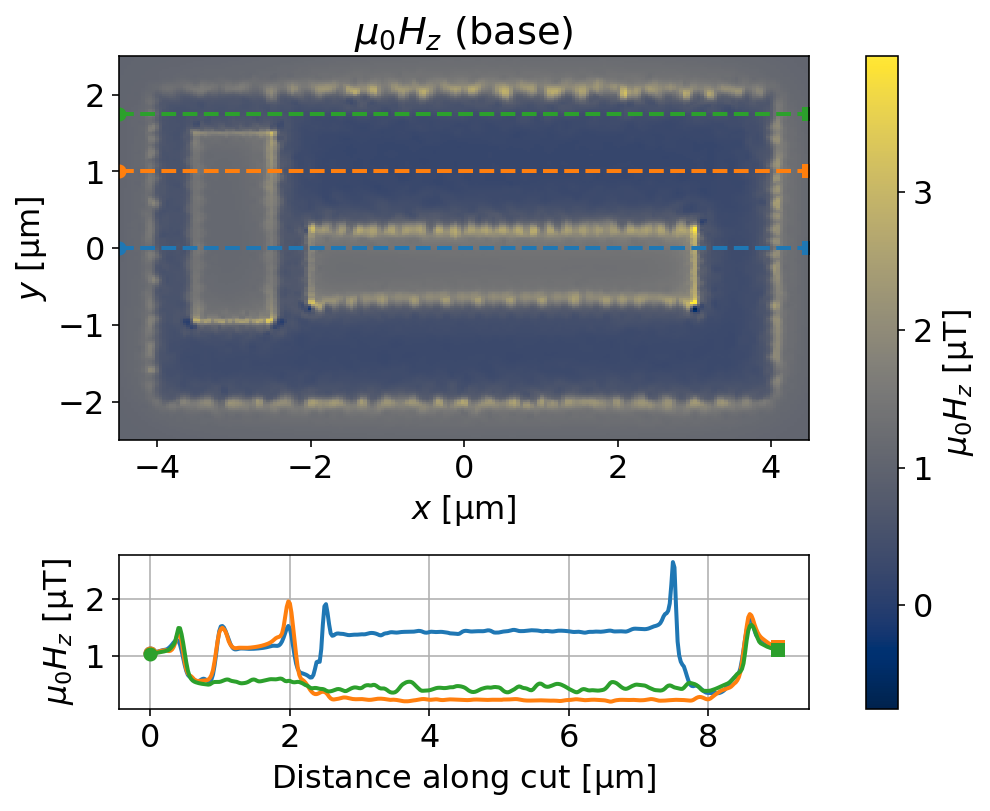

In [25]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords,
    auto_range_cutoff=0.01,
    figsize=(8, 6),
)

In [26]:
cross_section_coords = [
    np.stack([np.linspace(-4.5, 4.5, 401), y * np.ones(401)], axis=1)
    for y in (-1.1, 0, 1.1)
]

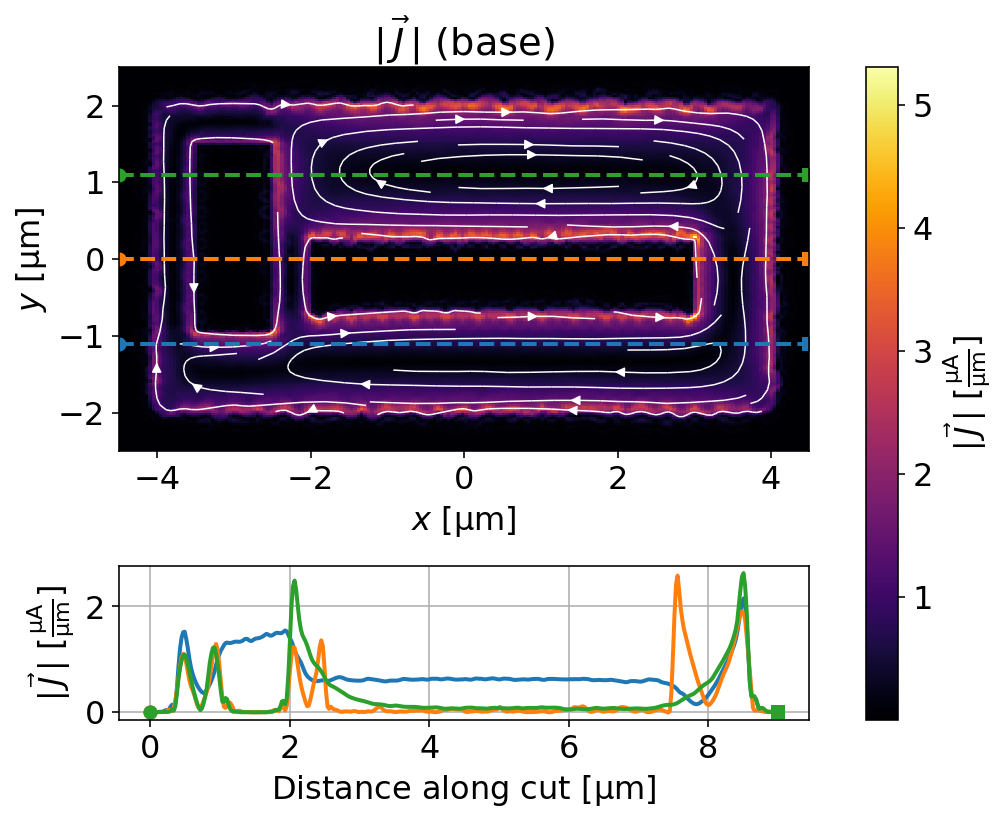

In [27]:
fig, axes = solution.plot_currents(
    units="uA/um",
    cross_section_coords=cross_section_coords,
    figsize=(8, 6),
)

### Trapped flux in one hole

INFO:superscreen.brandt:Calculating base response to applied field.


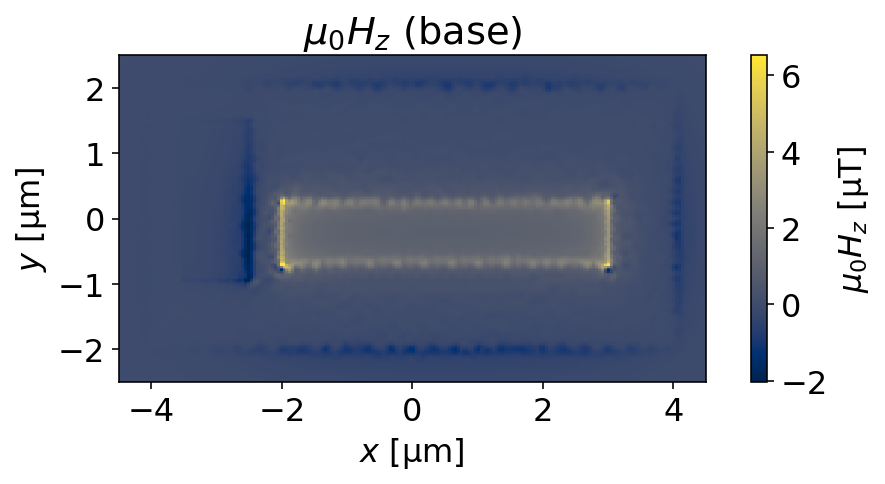

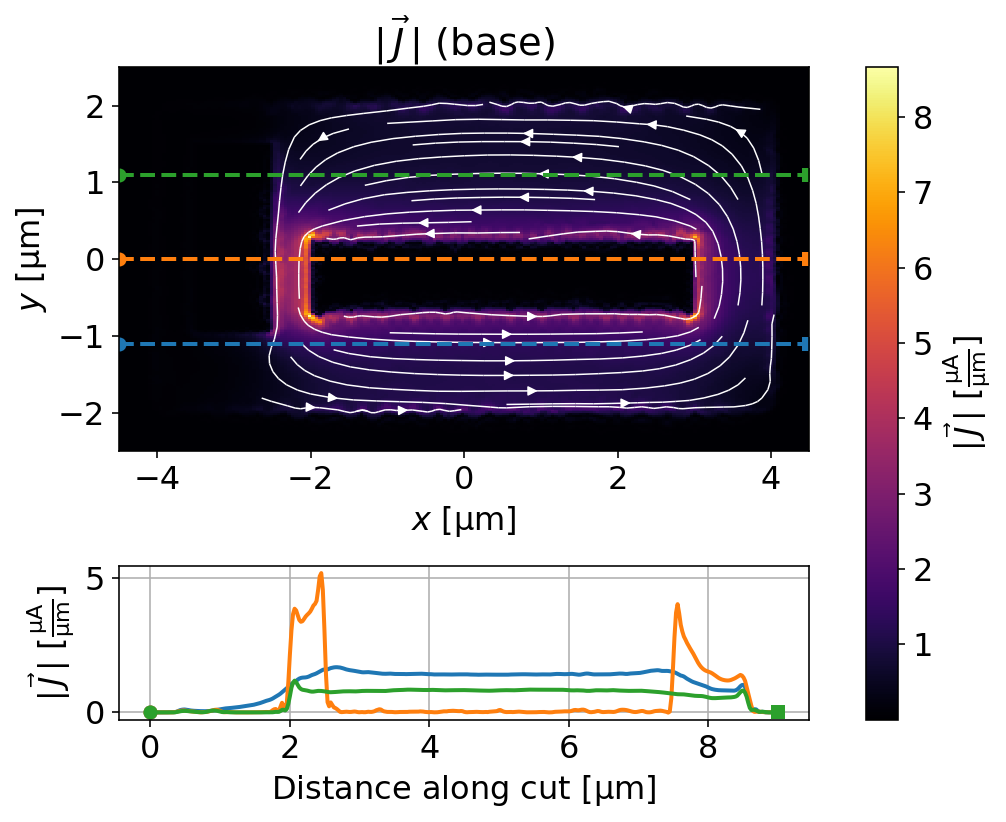

In [28]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "hole0": "2 uA",
    "hole1": "0 uA"
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="uT",
    current_units="uA",
)
solution = solutions[-1]

fig, axes = solution.plot_fields(
    auto_range_cutoff=0.01,
    figsize=(8, 3),
)

fig, axes = solution.plot_currents(
    units="uA/um",
    cross_section_coords=cross_section_coords,
    figsize=(8, 6),
)

### Trapped flux in the other hole

INFO:superscreen.brandt:Calculating base response to applied field.


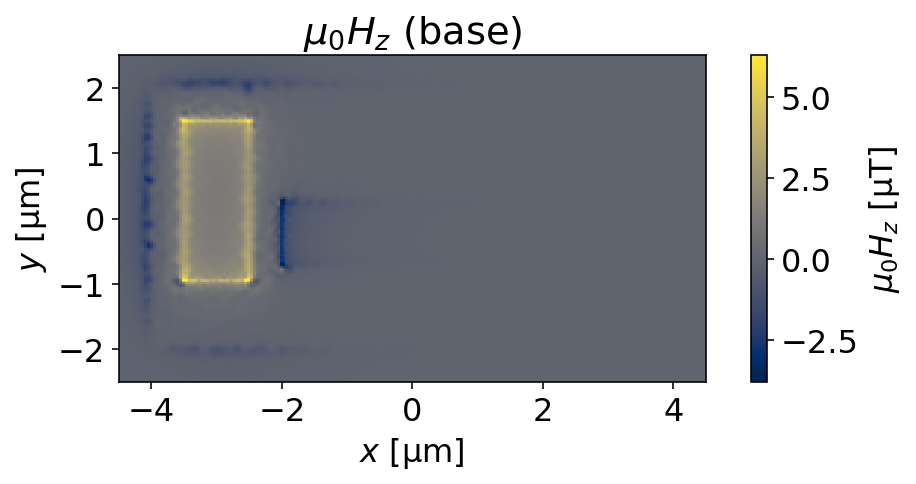

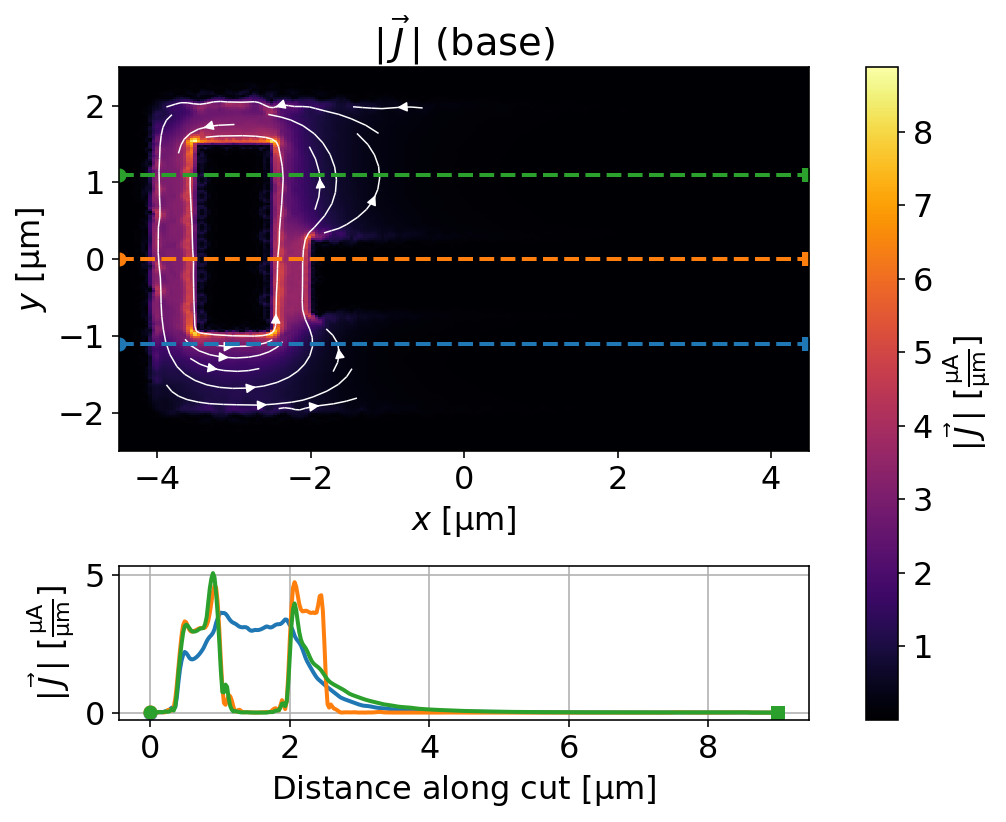

In [29]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "hole0": "0 uA",
    "hole1": "2 uA"
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="uT",
    current_units="uA",
)
solution = solutions[-1]

fig, axes = solution.plot_fields(
    auto_range_cutoff=0.01,
    figsize=(8, 3),
)

fig, axes = solution.plot_currents(
    units="uA/um",
    cross_section_coords=cross_section_coords,
    figsize=(8, 6),
)

### Trapped flux in both holes

INFO:superscreen.brandt:Calculating base response to applied field.


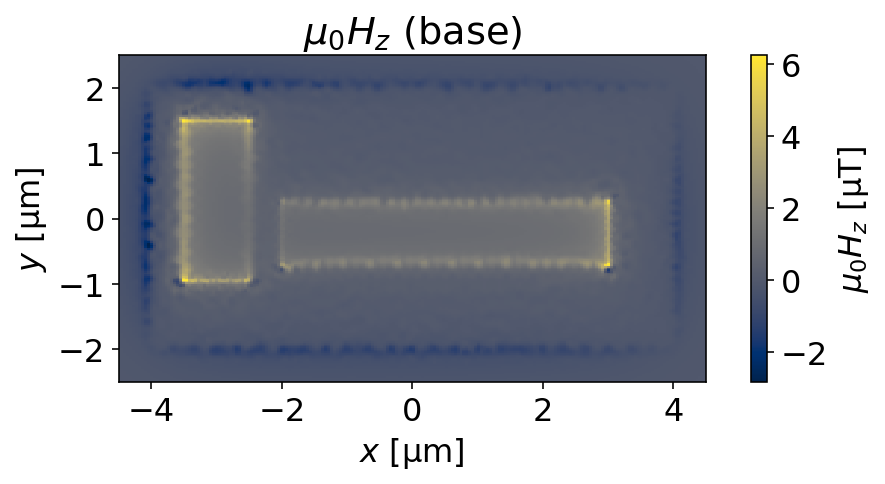

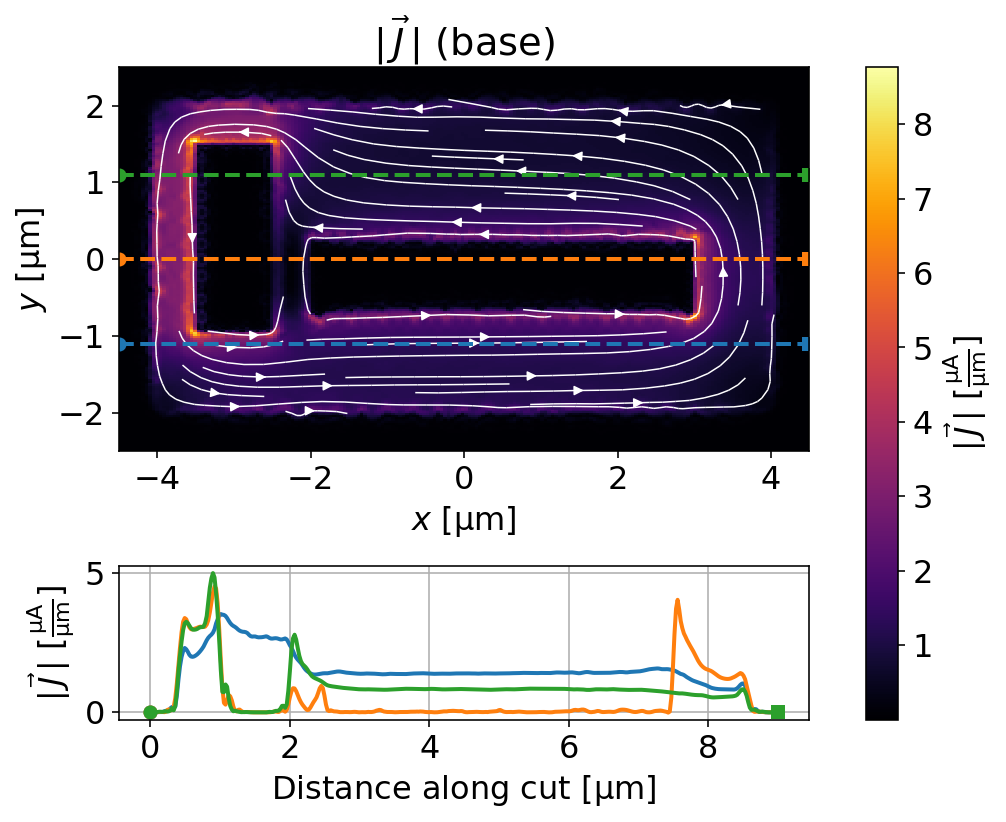

In [30]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "hole0": "2 uA",
    "hole1": "2 uA"
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="uT",
    current_units="uA",
)
solution = solutions[-1]

fig, axes = solution.plot_fields(
    auto_range_cutoff=0.01,
    figsize=(8, 3),
)

fig, axes = solution.plot_currents(
    units="uA/um",
    cross_section_coords=cross_section_coords,
    figsize=(8, 6),
)

### Non-uniform applied field

So far we have only seen uniform applied fields. Here we demonstrate how to model an inhomogenous applied field.

We will use a superposition of isolated vortices, each located at position $\vec{r}_i=(x_i, y_i, z_i)$:

$$\mu_0H_z(\vec{r}) = \mu_0H_z(x, y, z) = \sum_i \frac{1}{2\pi}\frac{(\vec{r}-\vec{r}_i)\cdot\hat{z}}{|\vec{r}-\vec{r}_i|^{3}}$$

In [31]:
def vortex_field(x, y, z, vortex_position=(0, 0, 0), nPhi0=1):
    """The field from an isolated vortex pinned in a bulk superconductor.

    Args:
        x, y, z: Position coordinates.
        vortex_position: (x, y, z) position of the vortex.
        nPhi0: Number of flux quanta contained in the vortex.
        
    Returns:
        Magnetic field in units of Phi_0 / (length_units)^2,
        where length_units are the units of x, y, z, etc.
    """
    xv, yv, zv = vortex_position
    xp = x - xv
    yp = y - yv
    zp = z - zv
    Bz0 = zp / (xp ** 2 + yp ** 2 + zp ** 2) ** (3 / 2) / (2 * np.pi)
    return nPhi0 * Bz0

Define the applied field:

In [32]:
vortex_z = -0.4 # Vortices located in a plane 400 nm below our device
vortex_positions = [
    ( 0.0,  0.0),
    (-2.3, -0.5),
    ( 2.0,  1.0),
    ( 1.5, -0.3),
    ( 4.0, -2.0),
    (-3.0,  1.5),
    (-4.0,  0.0),
]

applied_field = sum(
    sc.Parameter(vortex_field, vortex_position=(x, y, vortex_z))
    for x, y in vortex_positions
)

# Or equivalently, use the built in VortexField source:
# applied_field = sum(
#     sc.sources.VortexField(x0=x, y0=y, z0=vortex_z)
#     for x, y in vortex_positions
# )

Solve the model:

In [33]:
solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=None,
    field_units="Phi_0/um**2",
    current_units="uA",
)
solution = solutions[-1]

INFO:superscreen.brandt:Calculating base response to applied field.


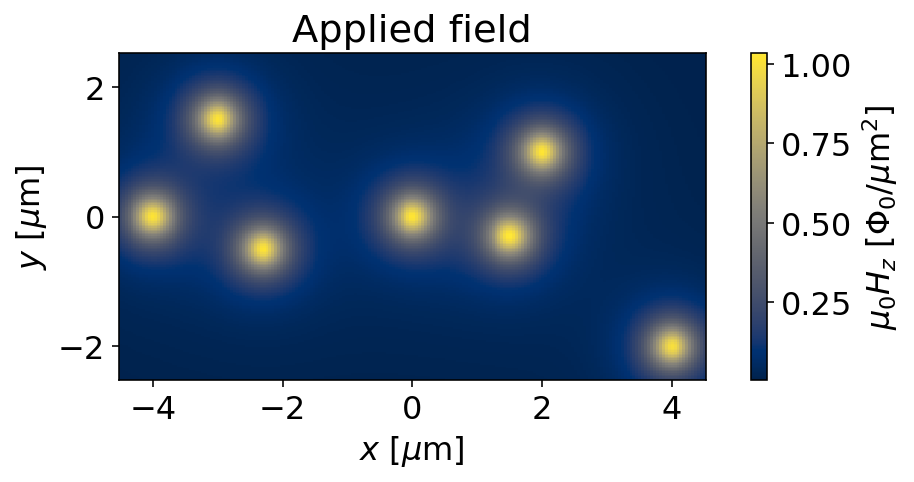

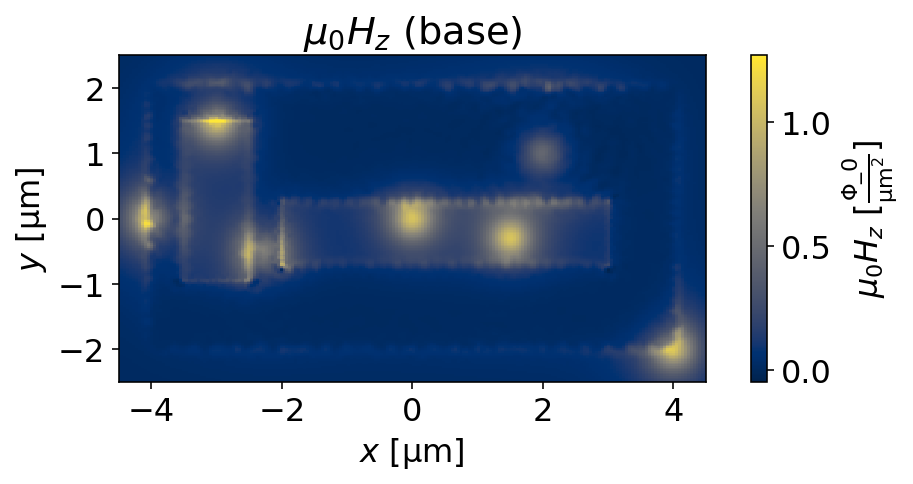

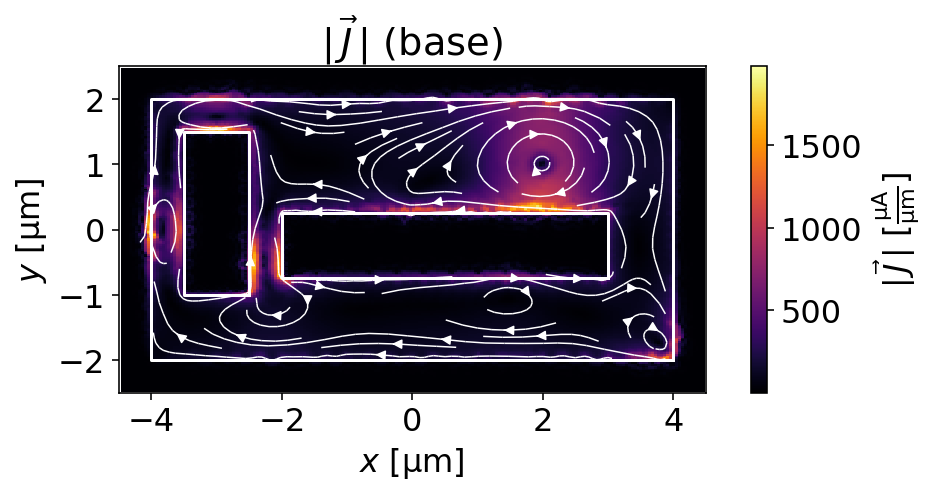

In [34]:
# Calculate and plot the applied field
xgrid, ygrid, _ = solution.grid_data("fields")
z = device.layers["base"].z0
Hz_applied = applied_field(xgrid, ygrid, z)

# Plot the applied field
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_aspect("equal")
ax.set_title("Applied field")
im = ax.pcolormesh(xgrid, ygrid, Hz_applied, cmap="cividis", shading="auto")
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$x$ [$\mu$m]")
ax.set_ylabel("$y$ [$\mu$m]")
cbar.set_label("$\mu_0H_z$ [$\Phi_0/\mu\mathrm{m}^2$]")

# Plot the total field and current
fig, axes = solution.plot_fields(auto_range_cutoff=0.01, figsize=(8, 3))
fig, axes = solution.plot_currents(units="uA/um", figsize=(8, 3))
fig, ax = device.plot_polygons(ax=axes[0], color='w', legend=False)

In [35]:
sc.version_table()

Software,Version
SuperScreen,0.1.1
Numpy,1.20.3
SciPy,1.6.3
matplotlib,3.4.3
ray,1.4.1
IPython,7.24.1
Python,"3.9.5 (default, May 18 2021, 12:31:01) [Clang 10.0.0 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 2, Logical: 4"
BLAS Info,OPENBLAS
